In [10]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu


### Считываем данные

In [11]:
# Принадлежность пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-naberezhnov-e-a013a/final_project/data/groups.csv', sep=';')
groups.head() 

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [12]:
# Пользователи, которых прислали спустя 2 дня после передачи данных 'groups'
group_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-naberezhnov-e-a013a/final_project/data/group_add.csv', sep=',')
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [13]:
# Пользователи, которые зашли на платформу в дни проведения эксперимента. 
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-naberezhnov-e-a013a/final_project/data/active_studs.csv')

# Добавляем пометку 'active' для всех пользователей online во время теста
active_studs['active'] = 'active'
active_studs.head()

,student_id,active
0,581585,active
1,5723133,active
2,3276743,active
3,4238589,active
4,4475369,active


In [14]:
# Информация об оплатах пользователей в дни проведения эксперимента. 
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-naberezhnov-e-a013a/final_project/data/checks.csv', sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


### Реализуем функцию, при применении которой, данные из group_add будут подтягиваться к основным данным, затем будут расчитаны метрики CR, ARPU, ARPPU

In [15]:
def load_new_users_and_refresh_data(URL: str):
    
    # Загружаем данные
    new_data = pd.read_csv(URL, sep=',')
    
    # Преобразовываем наименование столбцов для конкатинации с test_groups
    for column in new_data.columns:
        if pd.api.types.is_integer_dtype(new_data[column]):
            new_data.rename(columns={column: 'id'}, inplace=True)
        elif pd.api.types.is_object_dtype(new_data[column]):
            new_data.rename(columns={column: 'grp'}, inplace=True)
    
    # Делаем общий ДФ из group и принесенных позже group_add
    test_all_users_and_groups = pd.concat([groups, new_data], ignore_index=True)
    test_all_users_and_groups = test_all_users_and_groups.rename(columns={'id': 'student_id'})

    # Объединяем данные, заменяем пустые значения.
    test_all_users = (test_all_users_and_groups
                                 .merge(active_studs, on='student_id', how='outer')
                                 .merge(checks, on='student_id', how='outer')
                     )
    test_all_users['active'] = test_all_users['active'].fillna('non-active')
    test_all_users['rev'] = test_all_users['rev'].fillna(0)
    
    # Присваеваем статус user, совершившие оплату. 1 - оплатили, 0 - не оплатили.
    test_active_users = test_all_users.query("active == 'active'")
    test_active_users['paid_users'] = test_active_users['rev'].apply(lambda x: 1 if x > 0 else 0)
    
    #Готовим данный для рассчета метрик
    test_group_stats = (test_active_users
                               .groupby('grp', as_index=False)
                               .agg(
                                    total_users=('active', 'count'),
                                    paid_users=('paid_users', 'sum'),
                                    revenue=('rev', 'sum')
                                   )
                        )
    
    test_group_stats['revenue'] = round(test_group_stats['revenue'],0)
    
    #Рассчитываем метрики
    test_group_stats['CR_to_pay'] = round((test_group_stats.paid_users / test_group_stats.total_users)*100,2)
    test_group_stats['ARPU'] = round((test_group_stats.revenue / test_group_stats.total_users),2)
    test_group_stats['ARPPU'] = round((test_group_stats.revenue / test_group_stats.paid_users),2)

    return test_group_stats

Проверка работоспособности функции load_new_users_and_refresh_data. Данные сохраним в test_df.

In [16]:
file_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-naberezhnov-e-a013a/final_project/data/group_add.csv'
test_df = load_new_users_and_refresh_data(file_path)
test_df

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,grp,total_users,paid_users,revenue,CR_to_pay,ARPU,ARPPU
0,A,1538,78,72820.0,5.07,47.35,933.59
1,B,6803,314,394974.0,4.62,58.06,1257.88


### Реализуем функцию, которая построит барплот по нужным нам метрикам.

In [17]:
def plot_metrics_separately(df):
    # Устанавливаем базовый размер шрифта
    base_fontsize = 14
    title_fontsize = int(base_fontsize * 1.2)  # Увеличиваем на 20%
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    metrics = ['CR_to_pay', 'ARPU', 'ARPPU']
    titles = ['CR to pay, %', 'Average Revenue Per User (ARPU), руб.', 
             'Average Revenue Per Paying User (ARPPU), руб.']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        # Создаем barplot
        sns.barplot(x='grp', y=metric, data=df, 
                   palette=['skyblue', 'salmon'], 
                   ax=axes[i])
        
        # Настройки осей и заголовка с увеличенным шрифтом
        axes[i].set_title(title, pad=20, fontsize=title_fontsize)  # Увеличенный шрифт
        axes[i].set_ylabel('')
        axes[i].set_xlabel('Группа', fontsize=base_fontsize)
        
        # Убираем все подписи на оси Y
        axes[i].set_yticklabels([])
        axes[i].set_yticks([])
        
        # Добавляем значения на столбцы с увеличенным шрифтом
        for p in axes[i].patches:
            axes[i].annotate(f"{p.get_height():.1f}", 
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', 
                           xytext=(0, 10), 
                           textcoords='offset points',
                           fontsize=base_fontsize)
        
        # Увеличиваем верхний отступ графика
        axes[i].set_ylim(top=axes[i].get_ylim()[1] * 1.15)
    
    plt.tight_layout(pad=3.0)
    plt.show()

Проверка работоспособности функции plot_metrics_separately

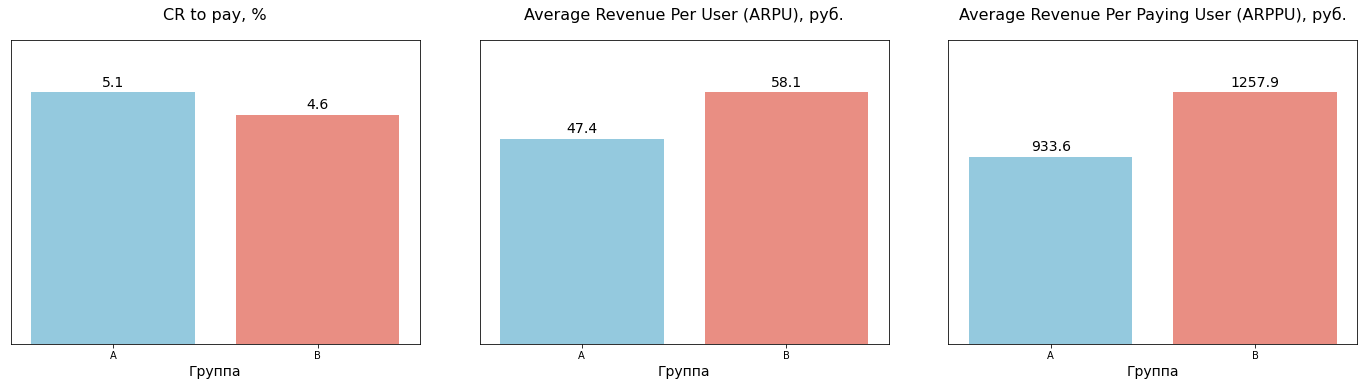

In [18]:
plot_metrics_separately(test_df)